<a href="https://colab.research.google.com/github/Vaish2511/Financial-Sentiment-Analysis-using-Knowledge-Distillation/blob/main/Financial_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
# Basic data handling and manipulation
import numpy as np
import pandas as pd
import warnings
from collections import Counter
import plotly.io as pio

# Visualization (optional, but useful for tracking metrics and understanding data)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot
from tqdm import tqdm

# TensorFlow and Keras for model development
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping

# For text preprocessing and tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, MaxPooling1D, Conv1D, Concatenate, Bidirectional, GlobalMaxPool1D, ActivityRegularization, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

#NLP modules
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# For data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing  import LabelEncoder

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/EE8228 Project/data.csv', encoding='latin-1', header = None)

In [ ]:
df.columns = ["News Headline", "Sentiment"]

In [ ]:
df.head()

,News Headline,Sentiment
0,Sentence,Sentiment
1,The GeoSolutions technology will leverage Bene...,positive
2,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
3,"For the last quarter of 2010 , Componenta 's n...",positive
4,According to the Finnish-Russian Chamber of Co...,neutral


In [ ]:
df.shape

(5843, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5843 entries, 0 to 5842
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   News Headline  5843 non-null   object
 1   Sentiment      5843 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [ ]:
df.describe(include = 'all')

,News Headline,Sentiment
count,5843,5843
unique,5323,4
top,The SeaWind that was en route from the Finnish...,neutral
freq,2,3130


In [ ]:
len(df[df.duplicated()])

6

In [ ]:
df = df.drop_duplicates()
print(df.head())
print(df.shape)

                                       News Headline  Sentiment
0                                           Sentence  Sentiment
1  The GeoSolutions technology will leverage Bene...   positive
2  $ESI on lows, down $1.50 to $2.50 BK a real po...   negative
3  For the last quarter of 2010 , Componenta 's n...   positive
4  According to the Finnish-Russian Chamber of Co...    neutral
(5837, 2)


In [ ]:
# Check if the 'News Headline' column exists and contains data
print(df.columns)  # List all columns
print(df['News Headline'].isnull().sum())  # Check for NaN values in 'News Headline'
print(df['News Headline'].head())  # Preview the first few rows of 'News Headline'

Index(['News Headline', 'Sentiment'], dtype='object')
0
0                                             Sentence
1    The GeoSolutions technology will leverage Bene...
2    $ESI on lows, down $1.50 to $2.50 BK a real po...
3    For the last quarter of 2010 , Componenta 's n...
4    According to the Finnish-Russian Chamber of Co...
Name: News Headline, dtype: object


In [ ]:
# Drop rows where 'News Headline' or 'Sentiment' is missing
df = df.dropna(subset=['News Headline', 'Sentiment'])

# Verify that rows are dropped correctly
print(df[['Sentiment', 'News Headline']].head())

   Sentiment                                      News Headline
0  Sentiment                                           Sentence
1   positive  The GeoSolutions technology will leverage Bene...
2   negative  $ESI on lows, down $1.50 to $2.50 BK a real po...
3   positive  For the last quarter of 2010 , Componenta 's n...
4    neutral  According to the Finnish-Russian Chamber of Co...


In [ ]:
# Ensure 'number_of_characters' is correctly calculated
df['number_of_characters'] = df['News Headline'].str.len()

# Check the first few rows to confirm 'number_of_characters' is created
print(df[['Sentiment', 'number_of_characters']].head())

   Sentiment  number_of_characters
0  Sentiment                     8
1   positive                   218
2   negative                    55
3   positive                   193
4    neutral                   128


In [ ]:
# Check for missing values or invalid labels in 'Sentiment'
print(df['Sentiment'].isnull().sum())  # Check for NaN values
print(df['Sentiment'].unique())  # Check unique sentiment labels

0
['Sentiment' 'positive' 'negative' 'neutral']


In [ ]:
# Remove rows where 'Sentiment' is the string 'Sentiment' (this might be a placeholder or header)
df = df[df['Sentiment'] != 'Sentiment']

# Check the unique values after cleaning
print(df['Sentiment'].unique())


['positive' 'negative' 'neutral']


In [ ]:
# Capitalize the sentiment labels for consistency
df['Sentiment'] = df['Sentiment'].str.capitalize()

# Verify the changes
print(df['Sentiment'].unique())

['Positive' 'Negative' 'Neutral']


Number Of Characters

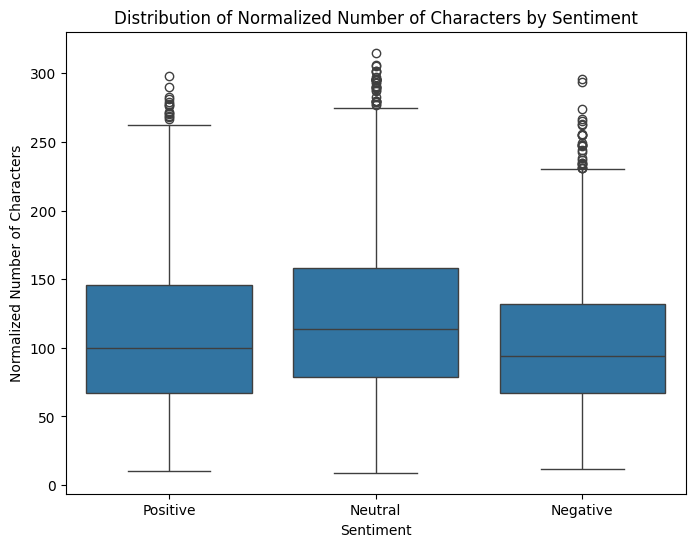

In [ ]:
# Ensure 'Sentiment' is categorical and ordered correctly
df['Sentiment'] = df['Sentiment'].astype('category')
df['Sentiment'] = df['Sentiment'].cat.reorder_categories(['Positive', 'Neutral', 'Negative'])

# Create the box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sentiment', y='number_of_characters', data=df)
plt.title('Distribution of Normalized Number of Characters by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Normalized Number of Characters')
plt.show()

Number of Words

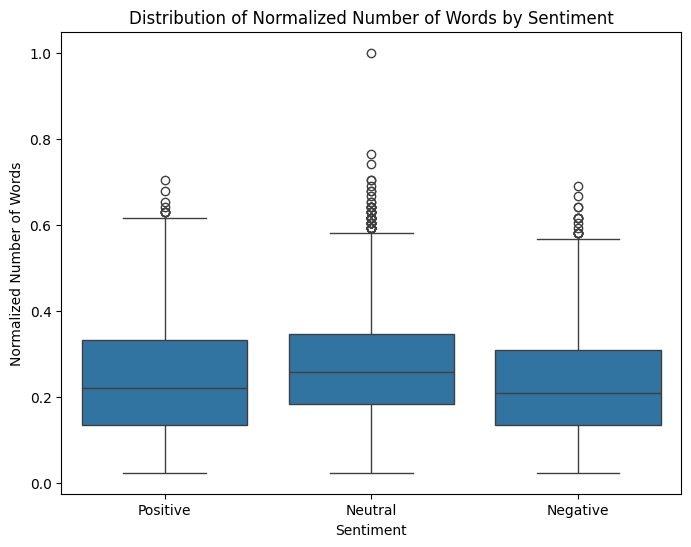

In [ ]:
# Step 1: Calculate the number of words in each 'News Headline'
df['number_of_words'] = df['News Headline'].str.split().str.len()

# Step 2: Normalize the number of words by dividing by the maximum number of words
df['number_of_words'] = df['number_of_words'] / df['number_of_words'].max()

# Step 3: Create the box plot for the distribution of normalized number of words by sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sentiment', y='number_of_words', data=df)
plt.title('Distribution of Normalized Number of Words by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Normalized Number of Words')
plt.show()

Number of Unique Words

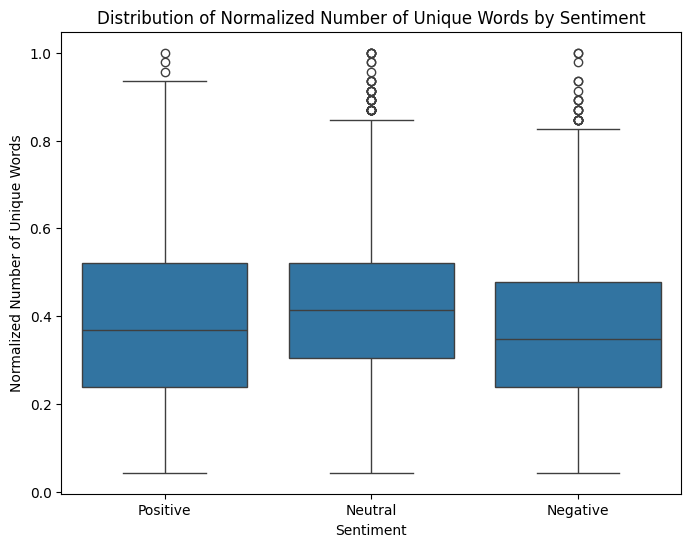

In [ ]:
# Step 1: Calculate the number of unique words in each 'News Headline'
df['unique_words'] = df['News Headline'].apply(lambda x: len(set(x.split())))

# Step 2: Normalize the number of unique words by dividing by the maximum number of unique words
df['unique_words'] = df['unique_words'] / df['unique_words'].max()

# Step 3: Create the box plot for the distribution of normalized number of unique words by sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sentiment', y='unique_words', data=df)
plt.title('Distribution of Normalized Number of Unique Words by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Normalized Number of Unique Words')
plt.show()

Number of Punctuation

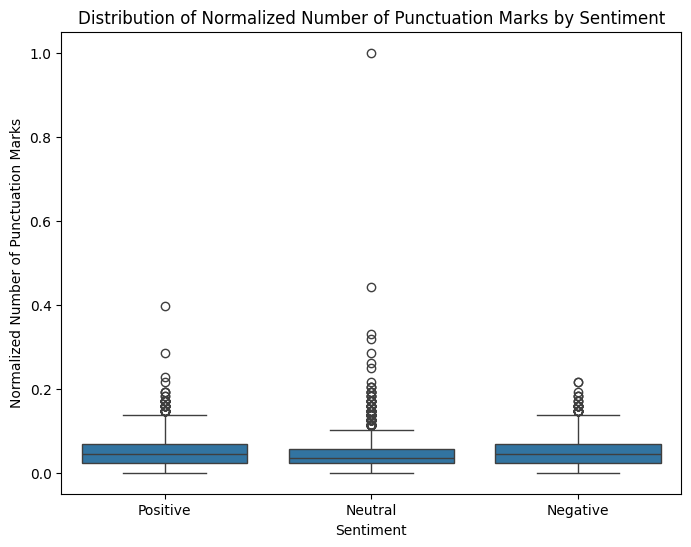

In [ ]:
import string

# Step 1: Calculate the number of punctuation marks in each 'News Headline'
df['num_punctuations'] = df['News Headline'].apply(lambda x: sum(1 for char in x if char in string.punctuation))

# Step 2: Normalize the number of punctuation marks by dividing by the maximum number of punctuation marks
df['num_punctuations'] = df['num_punctuations'] / df['num_punctuations'].max()

# Step 3: Create the box plot for the distribution of normalized punctuation count by sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sentiment', y='num_punctuations', data=df)
plt.title('Distribution of Normalized Number of Punctuation Marks by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Normalized Number of Punctuation Marks')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


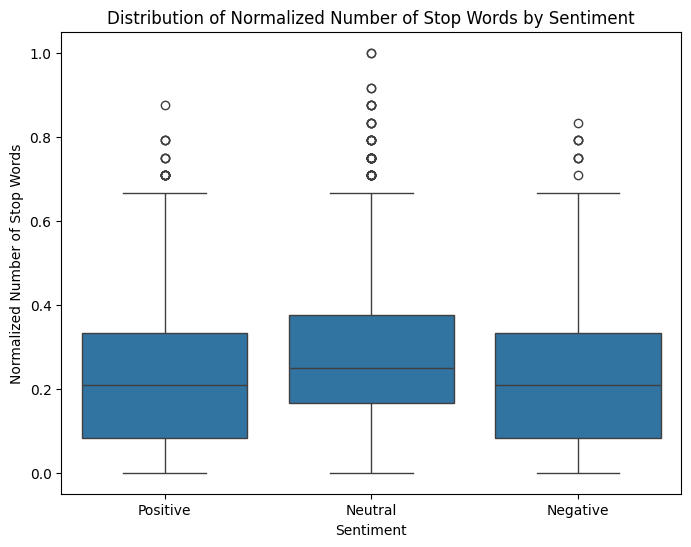

In [ ]:
# Step 1: Download NLTK stop words if not already downloaded
nltk.download('stopwords')

# Step 2: Get the list of stop words
stop_words = set(stopwords.words('english'))

# Step 3: Calculate the number of stop words in each 'News Headline'
df['num_stopwords'] = df['News Headline'].apply(lambda x: sum(1 for word in x.split() if word.lower() in stop_words))

# Step 4: Normalize the number of stop words by dividing by the maximum number of stop words
df['num_stopwords'] = df['num_stopwords'] / df['num_stopwords'].max()

# Step 5: Create the box plot for the distribution of normalized stop words by sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sentiment', y='num_stopwords', data=df)
plt.title('Distribution of Normalized Number of Stop Words by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Normalized Number of Stop Words')
plt.show()

Feature Correlation Matrix

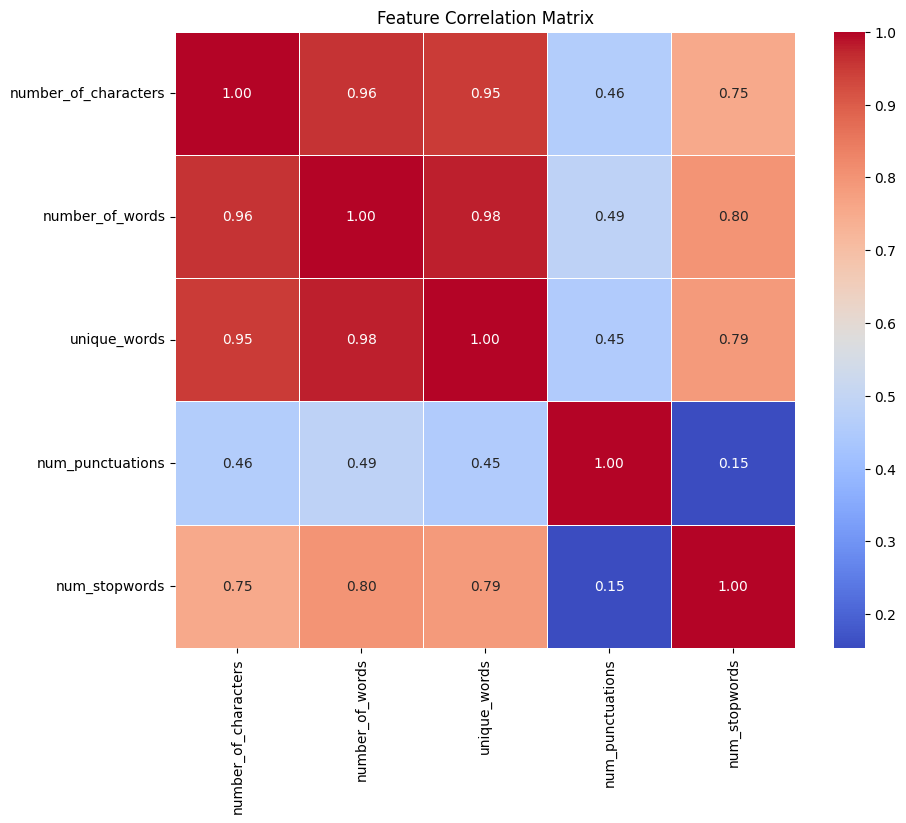

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure we have the necessary features in the dataframe
features = ['number_of_characters', 'number_of_words', 'unique_words', 'num_punctuations', 'num_stopwords']

# Step 1: Calculate the correlation matrix between the features
correlation_matrix = df[features].corr()

# Step 2: Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

<ipython-input-71-b2b546bd139f>:9: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



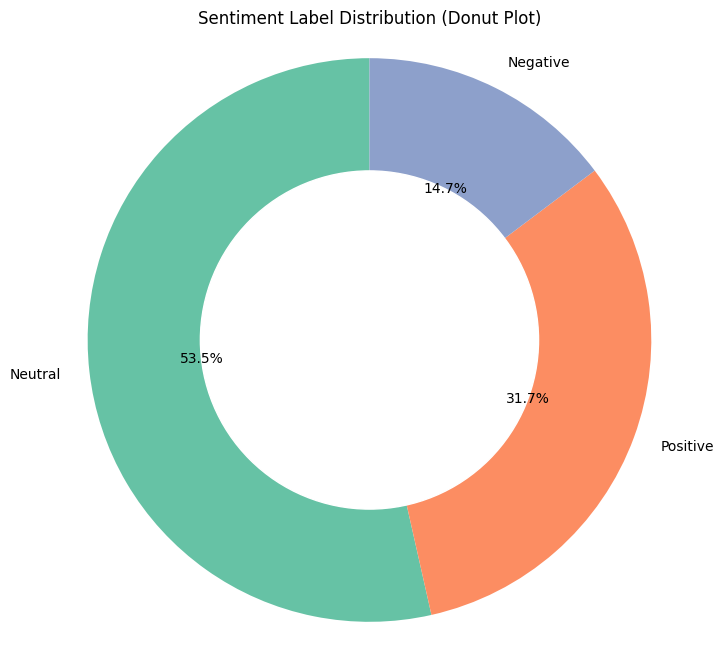

In [ ]:
# Step 1: Calculate the distribution of sentiment labels
sentiment_counts = df['Sentiment'].value_counts()

# Step 2: Create the donut plot
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(sentiment_counts)))

# Create a hole in the center (donut shape)
centre_circle = plt.Circle((0,0), 0.60, color='white', fc='white', edgecolor='white')
plt.gca().add_artist(centre_circle)

# Step 3: Display the plot
plt.title('Sentiment Label Distribution (Donut Plot)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
df = df[df['Sentiment'] != 'Sentiment']
# Check the unique values after cleaning
print(df['Sentiment'].unique())
df['Sentiment'] = df['Sentiment'].str.capitalize()
# Verify the changes
print(df['Sentiment'].unique())

['Positive', 'Negative', 'Neutral']
Categories (3, object): ['Positive', 'Neutral', 'Negative']
['Positive' 'Negative' 'Neutral']


In [ ]:
import re
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and lowercase
    tokens = text.split()  # Tokenize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

df['Cleaned Headline'] = df['News Headline'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
from transformers import pipeline

# Load pre-trained model for sentiment analysis
teacher_model = pipeline('sentiment-analysis')

# Generate weak labels using teacher model
def weak_labeling(text):
    prediction = teacher_model(text)[0]
    label = prediction['label']
    # Map the output to match your sentiment labels
    return 'Positive' if label == 'POSITIVE' else 'Negative' if label == 'NEGATIVE' else 'Neutral'

df['Weak Label'] = df['Cleaned Headline'].apply(weak_labeling)
print(df[['News Headline', 'Weak Label']].head())

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


                                       News Headline Weak Label
1  The GeoSolutions technology will leverage Bene...   Positive
2  $ESI on lows, down $1.50 to $2.50 BK a real po...   Negative
3  For the last quarter of 2010 , Componenta 's n...   Negative
4  According to the Finnish-Russian Chamber of Co...   Positive
5  The Swedish buyout firm has sold its remaining...   Negative


In [ ]:
from sklearn.model_selection import train_test_split

X = df['Cleaned Headline']
y = df['Weak Label']  # Use weak labels as the target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # Limit vector size
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
from tensorflow.keras import layers, models

# Define the student model
student_model = models.Sequential([
    layers.Input(shape=(5000,)),  # Match vectorizer output
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')  # 3 classes: Positive, Neutral, Negative
])

student_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Encode labels as integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Train the student model
student_model.fit(X_train_vec, y_train_enc, epochs=10, batch_size=32, validation_data=(X_test_vec, y_test_enc))

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6426 - loss: 0.8975 - val_accuracy: 0.7012 - val_loss: 0.5557
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7945 - loss: 0.4720 - val_accuracy: 0.7894 - val_loss: 0.4532
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9012 - loss: 0.2915 - val_accuracy: 0.7979 - val_loss: 0.4431
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9511 - loss: 0.1798 - val_accuracy: 0.7928 - val_loss: 0.4681
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9708 - loss: 0.1192 - val_accuracy: 0.7877 - val_loss: 0.5072
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9843 - loss: 0.0863 - val_accuracy: 0.7851 - val_loss: 0.5485
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9898 - loss: 0.0571 - val_accuracy: 0.7817 - val_loss: 0.5993
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9951 - loss: 0.0420 - val_accu

In [ ]:
# Evaluate the student model
loss, accuracy = student_model.evaluate(X_test_vec, y_test_enc)
print(f"Test Accuracy: {accuracy:.2f}")

# Save the student model
student_model.save('student_model.h5')

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7768 - loss: 0.7498


Test Accuracy: 0.78


In [ ]:
# Load pre-trained sentiment analysis pipeline
teacher_model = pipeline('sentiment-analysis')

# Enhanced weak labeling
def weak_labeling_with_meta_context(text):
    prediction = teacher_model(text)[0]
    label = 'Positive' if prediction['label'] == 'POSITIVE' else 'Negative' if prediction['label'] == 'NEGATIVE' else 'Neutral'
    return {'label': label, 'score': prediction['score']}  # Include confidence score

df['Meta Context'] = df['Cleaned Headline'].apply(weak_labeling_with_meta_context)
df['Weak Label'] = df['Meta Context'].apply(lambda x: x['label'])
df['Confidence'] = df['Meta Context'].apply(lambda x: x['score'])
print(df[['News Headline', 'Weak Label', 'Confidence']].head())

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


                                       News Headline Weak Label  Confidence
1  The GeoSolutions technology will leverage Bene...   Positive    0.993101
2  $ESI on lows, down $1.50 to $2.50 BK a real po...   Negative    0.958114
3  For the last quarter of 2010 , Componenta 's n...   Negative    0.994215
4  According to the Finnish-Russian Chamber of Co...   Positive    0.946110
5  The Swedish buyout firm has sold its remaining...   Negative    0.950514


In [ ]:
# Align df['Confidence'] with X_train_vec and y_train_enc
df = df.iloc[:X_train_vec.shape[0]]  # Adjust df to match the size of X_train_vec
df['Confidence'] = df['Confidence'].iloc[:X_train_vec.shape[0]]  # Filter 'Confidence' column

In [ ]:
# Define the meta-learning student model
class MetaLearningStudent(tf.keras.Model):
    def __init__(self, input_dim):
        super(MetaLearningStudent, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dropout = layers.Dropout(0.2)
        self.dense2 = layers.Dense(3, activation='softmax')  # 3 classes: Positive, Neutral, Negative

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dropout(x, training=training)
        return self.dense2(x)

# Initialize model
input_dim = 5000  # Match vectorizer output size
meta_student_model = MetaLearningStudent(input_dim)

# Custom training loop for meta-learning
# Custom training loop for meta-learning
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()

def train_step(x_dense, y, confidence):
    with tf.GradientTape() as tape:
        predictions = meta_student_model(x_dense, training=True)
        loss = loss_fn(y, predictions) - tf.reduce_mean(confidence * tf.math.log(tf.reduce_max(predictions, axis=1)))
    gradients = tape.gradient(loss, meta_student_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, meta_student_model.trainable_variables))
    metric.update_state(y, predictions)
    return loss

# Ensure X_train_vec, y_train_enc, and confidence values have the same length
assert X_train_vec.shape[0] == len(y_train_enc) == len(df['Confidence'])  # This should pass after filtering

batch_size = 32
epochs = 10
num_batches = X_train_vec.shape[0] // batch_size

batch_size = 32
epochs = 10
num_batches = X_train_vec.shape[0] // batch_size

for epoch in range(epochs):
    for batch_start in range(0, X_train_vec.shape[0], batch_size):
        batch_end = min(batch_start + batch_size, X_train_vec.shape[0])
        # Convert sparse to dense for the current batch
        x_batch = tf.convert_to_tensor(X_train_vec[batch_start:batch_end].toarray(), dtype=tf.float32)
        y_batch = y_train_enc[batch_start:batch_end]
        conf_batch = df['Confidence'].iloc[batch_start:batch_end].values

        # Train on the batch
        loss = train_step(x_batch, y_batch, conf_batch)

    print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}, Accuracy: {metric.result().numpy()}")
    metric.reset_state()  # Correct method to reset the metric

Epoch 1, Loss: 0.914579451084137, Accuracy: 0.655098557472229
Epoch 2, Loss: 0.7544665336608887, Accuracy: 0.6670951247215271
Epoch 3, Loss: 0.43801015615463257, Accuracy: 0.834404468536377
Epoch 4, Loss: 0.22660097479820251, Accuracy: 0.904455840587616
Epoch 5, Loss: 0.1146482527256012, Accuracy: 0.9312339425086975
Epoch 6, Loss: 0.05050946772098541, Accuracy: 0.9507283568382263
Epoch 7, Loss: 0.03215198218822479, Accuracy: 0.9659383296966553
Epoch 8, Loss: 0.033062003552913666, Accuracy: 0.9783633351325989
Epoch 9, Loss: 0.015004990622401237, Accuracy: 0.9858611822128296
Epoch 10, Loss: 0.021168380975723267, Accuracy: 0.9910025596618652


In [ ]:
# Define the meta-learning student model
class MetaLearningStudent(tf.keras.Model):
    def __init__(self, input_dim, **kwargs):
        super(MetaLearningStudent, self).__init__(**kwargs)
        self.dense1 = layers.Dense(128, activation='relu')
        self.dropout = layers.Dropout(0.2)
        self.dense2 = layers.Dense(3, activation='softmax')  # 3 classes: Positive, Neutral, Negative

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dropout(x, training=training)
        return self.dense2(x)

# Initialize the model
input_dim = 5000  # Match vectorizer output size
meta_student_model = MetaLearningStudent(input_dim)

# Optimizer, loss, and metric
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()

def reflection_loss_fn(predictions, confidence, y_true):
    confidence = tf.cast(confidence, tf.float32)
    y_true = tf.cast(y_true, tf.int64)
    max_conf = tf.reduce_max(predictions, axis=1)

    # Penalize high confidence in incorrect predictions
    incorrect_conf_penalty = tf.reduce_mean(
        confidence * tf.math.log(max_conf + 1e-8) * tf.cast(
            tf.not_equal(tf.argmax(predictions, axis=1), y_true), tf.float32
        )
    )
    return incorrect_conf_penalty

@tf.function
def train_step(x, y, confidence):
    with tf.GradientTape() as tape:
        predictions = meta_student_model(x, training=True)
        primary_loss = loss_fn(y, predictions)
        reflective_loss = reflection_loss_fn(predictions, confidence, y)
        combined_loss = primary_loss + 0.1 * reflective_loss  # Weighted combination
    gradients = tape.gradient(combined_loss, meta_student_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, meta_student_model.trainable_variables))
    metric.update_state(y, predictions)
    return combined_loss

# Training loop with self-reflection
batch_size = 32
epochs = 10
for epoch in range(epochs):
    for batch_start in range(0, X_train_vec.shape[0], batch_size):
        batch_end = batch_start + batch_size
        x_batch = tf.convert_to_tensor(X_train_vec[batch_start:batch_end].toarray(), dtype=tf.float32)
        y_batch = y_train_enc[batch_start:batch_end]
        conf_batch = df['Confidence'].iloc[batch_start:batch_end].values

        loss = train_step(x_batch, y_batch, conf_batch)

    print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}, Accuracy: {metric.result().numpy()}")
    metric.reset_state()  # Reset accuracy for the next epoch

Epoch 1, Loss: 0.6030843257904053, Accuracy: 0.665595531463623
Epoch 2, Loss: 0.3310389220714569, Accuracy: 0.8294773101806641
Epoch 3, Loss: 0.19403384625911713, Accuracy: 0.9027420878410339
Epoch 4, Loss: 0.10382836312055588, Accuracy: 0.9428020715713501
Epoch 5, Loss: 0.06949442625045776, Accuracy: 0.9685090184211731
Epoch 6, Loss: 0.03791813552379608, Accuracy: 0.9809340238571167
Epoch 7, Loss: 0.02540944330394268, Accuracy: 0.9886460900306702
Epoch 8, Loss: 0.017023403197526932, Accuracy: 0.9959297180175781
Epoch 9, Loss: 0.011764940805733204, Accuracy: 0.9978577494621277
Epoch 10, Loss: 0.00777482520788908, Accuracy: 0.998500406742096
